<a href="https://colab.research.google.com/github/rushweigelt/rushweigelt.github.io/blob/master/DL_Foundation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rush Weigelt


1/10/20
First Attempt at DL Pictionary
Based on Zaid Alyafeai's Medium Article
(Thank You for the incredible walkthrough!)

In [1]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2020-01-10 23:40:35--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt.2’

mini_classes.txt.2  100%[===================>]     760  --.-KB/s    in 0s      

2020-01-10 23:40:36 (230 MB/s) - ‘mini_classes.txt.2’ saved [760/760]



In [0]:
f = open("mini_classes.txt", "r")
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [26]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import urllib.request
import matplotlib.pyplot as plt
import random
from google.colab import files

vfold_ratio = 0.2
max_images_per_class = 5000
validation_split = 0.1
batch_size = 256
verbose = 2
epochs=5

#Start by Downloading Data from Google
def download_data():

  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', "%20")
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')


In [30]:
download_data()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

In [0]:
#Load the subset of data we want
#Will return: X Train Set, X Test Set, Y Train Set, Y Test Set, and Class Names
def load_data(root, vfold_ratio=vfold_ratio, max_items_per_class=max_images_per_class):
  all_files = glob.glob(os.path.join(root, '*.npy'))

  #init vars
  x = np.empty([0, 784])
  y = np.empty([0])
  class_names = []

  #load a subset of the data into memory
  for idx, file in enumerate(all_files):
    data = np.load(file)
    data = data[0: max_items_per_class, :]
    labels = np.full(data.shape[0], idx)

    x = np.concatenate((x, data), axis=0)
    y = np.append(y, labels)

    class_name, ext = os.path.splitext(os.path.basename(file))
    class_names.append(class_name)

  data = None
  labels = None

  #Seperate into training and testing datasets
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

  x_test = x[0:vfold_size, :]
  y_test = y[0:vfold_size]

  x_train = x[vfold_size:x.shape[0], :]
  y_train = y[vfold_size:y.shape[0]]

  return x_train, y_train, x_test, y_test, class_names

In [4]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28
print(len(x_train))

400000


In [0]:
#show a random drawing we downloaded earlier
def mini_test_show_rand_data():
  %matplotlib inline
  idx = random.randint(0, len(x_train))
  plt.imshow(x_train[idx].reshape(28,28))
  print(class_names[int(y_train[idx].item())])

triangle


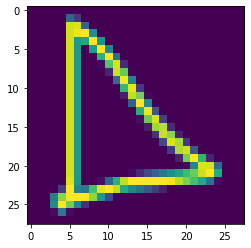

In [6]:
mini_test_show_rand_data()

In [0]:
def preprocess_data(x_train, x_test, y_train, y_test):
  #Reshape and Normalize
  x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
  x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

  x_train /= 255.0
  x_test /= 255.0

  #convert class vectors to matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  return x_train, x_test, y_train, y_test

In [0]:
x_train, x_test, y_train, y_test = preprocess_data(x_train, x_test, y_train, y_test)

In [0]:
def define_model(x_train):
  model = keras.Sequential()
  #Convolution > Pool > Convolution > Pool > Convolution > Pool > Flatten > Dense > Dense
  #Convo > Pool batch
  model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  #Rest
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  return model




In [10]:
model = define_model(x_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def train_model(loss, metrics):
  adam = tf.train.AdamOptimizer()
  model.compile(loss=loss, optimizer=adam, metrics=[metrics])
  print(model.summary())

In [13]:
trained_model = train_model('categorical_crossentropy', 'top_k_categorical_accuracy')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0

In [14]:
model.fit(x = x_train, y = y_train, validation_split=validation_split, batch_size = batch_size, verbose=verbose, epochs=epochs)

Train on 360000 samples, validate on 40000 samples
Epoch 1/5
360000/360000 - 18s - loss: 1.8959 - top_k_categorical_accuracy: 0.7885 - val_loss: 1.3742 - val_top_k_categorical_accuracy: 0.8767
Epoch 2/5
360000/360000 - 9s - loss: 1.2676 - top_k_categorical_accuracy: 0.8905 - val_loss: 1.2076 - val_top_k_categorical_accuracy: 0.8967
Epoch 3/5
360000/360000 - 9s - loss: 1.1259 - top_k_categorical_accuracy: 0.9061 - val_loss: 1.0942 - val_top_k_categorical_accuracy: 0.9094
Epoch 4/5
360000/360000 - 9s - loss: 1.0442 - top_k_categorical_accuracy: 0.9146 - val_loss: 1.0346 - val_top_k_categorical_accuracy: 0.9151
Epoch 5/5
360000/360000 - 10s - loss: 0.9871 - top_k_categorical_accuracy: 0.9204 - val_loss: 1.0101 - val_top_k_categorical_accuracy: 0.9176


In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:0.2f}%'.format(score[1]*100))

Test accuracy: 91.89%


In [17]:
model.save('keras.h5')

In [18]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 17.3MB 202kB/s 
     |████████████████████████████████| 256kB 50.5MB/s 
     |████████████████████████████████| 901kB 64.4MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32853 sha256=15fcac2252b43f7faa6d35f5395def430d81f1fdac1875fb796807c8f99bd6c9
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.11.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully unins

In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

In [20]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/group1-shard1of1.bin (deflated 7%)
  adding: model/model.json (deflated 85%)


In [0]:
files.download('model.zip')